In [1]:
import numpy as np
import configparser
import pandas as pd
import tdr_utils as ut

In [2]:
# Get parameters from configuration file
config = configparser.ConfigParser()
config.read('tdr-parameters.ini')

c = float(config['signal']['c']) #speed of light
vf = float(config['signal']['vf']) #velocity factor
threshold = int(config['signal']['threshold'])
frequency = float(config['signal']['frequency'])
duty_cycle = float(config['signal']['duty_cycle'])
num_samples = int(config['signal']['num_samples'])
sampling_rate = float(config['signal']['sampling_rate'])

num_edges = int(config['search']['num_edges']) #number of rising and falling, each, edges to search for
overlap_offset = int(config['search']['overlap_offset']) #number of samples to offset overlap threshold with

win_size = int(config['win_interest']['win_size']) 
prior_samples = int(config['win_interest']['prior_samples']) # samples to consider before rising/falling edge index

_num_edges = 1
overlap_threshold = duty_cycle * (sampling_rate / frequency) - overlap_offset
t = np.linspace(0, num_samples / sampling_rate, num=num_samples) * 1000 #time in milliseconds

### 93.26 m
Short circuit at 93.26 m from the input port

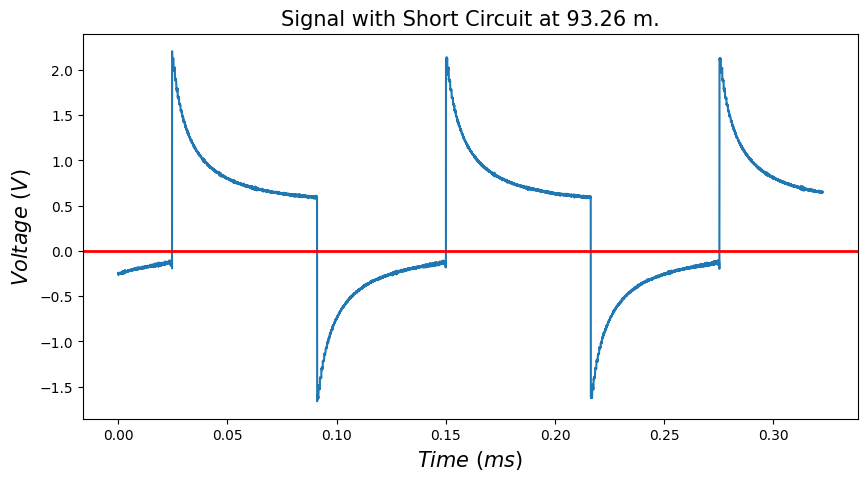

In [3]:
short_93m_files_dir = './data/short-circuit/93m'

#load a random file
v_short_93m = ut.random_file_load(short_93m_files_dir, num_samples, threshold)

#plot the loaded signal
ut.single_plot(t, v_short_93m, 'Signal with Short Circuit at 93.26 m.')

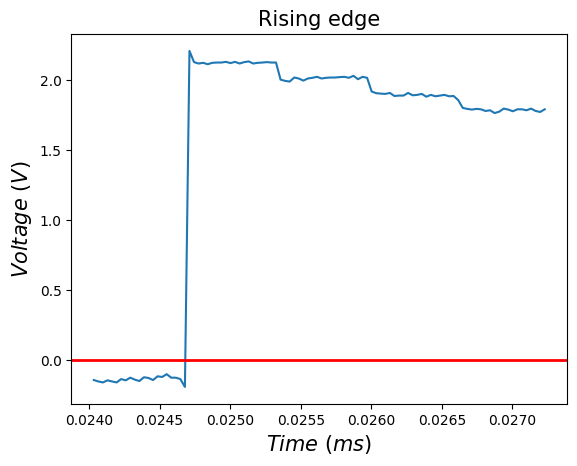

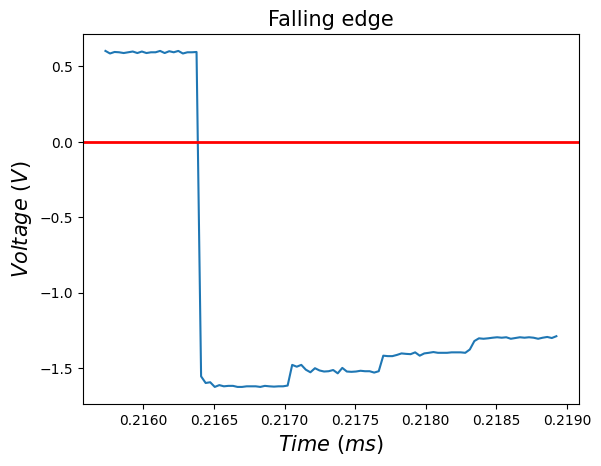

In [4]:
#locate rising a rising edge and a falling edge in the signal
short_93m_edges_indices = ut.edges_detection(v_short_93m, t, _num_edges, win_size, prior_samples, overlap_threshold)

#plot rising and falling edges
ut.edges_plots(v_short_93m, t, short_93m_edges_indices, win_size, prior_samples)

#### 1. Rising edge

Change point detection on a rising edge

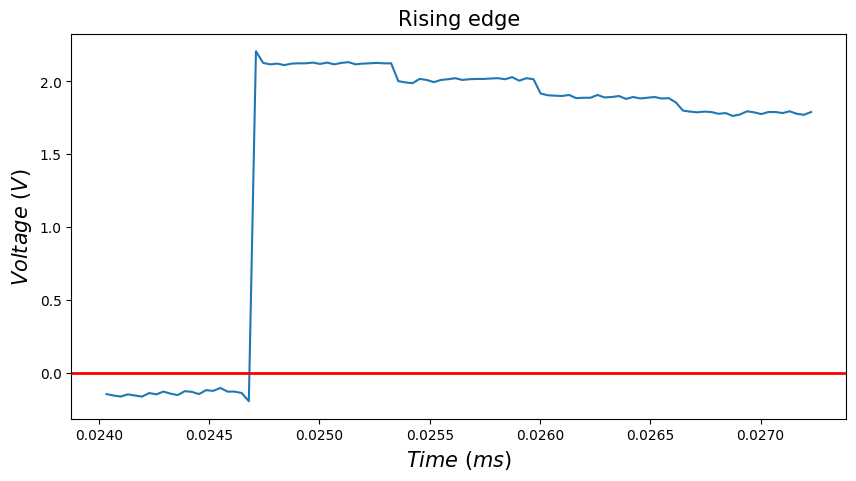

In [5]:
rising_edge_indx = short_93m_edges_indices['rising_edges'][0]
t_rising_seg, v_rising_seg = ut.win_generator(v_short_93m, t, rising_edge_indx, win_size, prior_samples)

plot_title = 'Rising edge'
ut.single_plot(t_rising_seg, v_rising_seg, plot_title)

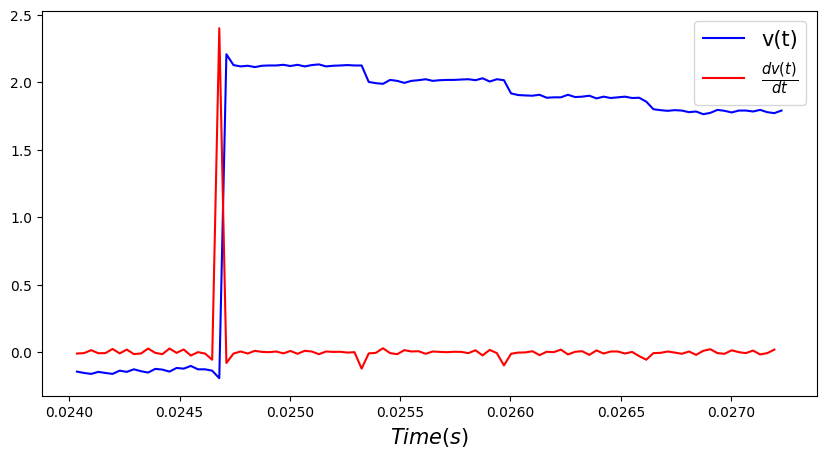

In [6]:
#let's plot the derivative of the signal and the signal
s_rising_derivative = ut.sig_derivative(v_rising_seg, t_rising_seg)

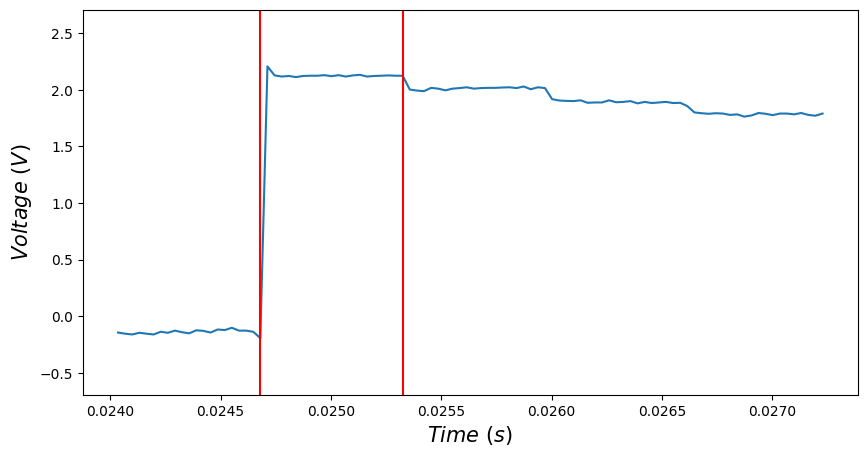

Timed delay is 0.0006452258129038685 ms


In [7]:
t_rising_delay = ut.time_delay(v_rising_seg, t_rising_seg, display=True)
print('Timed delay is {} ms'.format(t_rising_delay))

In [8]:
p_rising_fault = ut.fault_point(t_rising_delay, c, vf)

print('Distance to the fault is {} m'.format(p_rising_fault))

Distance to the fault is 94.71269707615886 m


In [9]:
#model performance
performance = ut.performance_metrics(93.26, p_rising_fault, metrics=['mse'])
print('Model performance metrics outcome for a single rising edge:', performance)

Model performance metrics outcome for a single rising edge: Metrics(mse=2.1103287950804885, rmse=1.4526970761588558)


#### 2. Falling edge

Change point detection on a falling edge

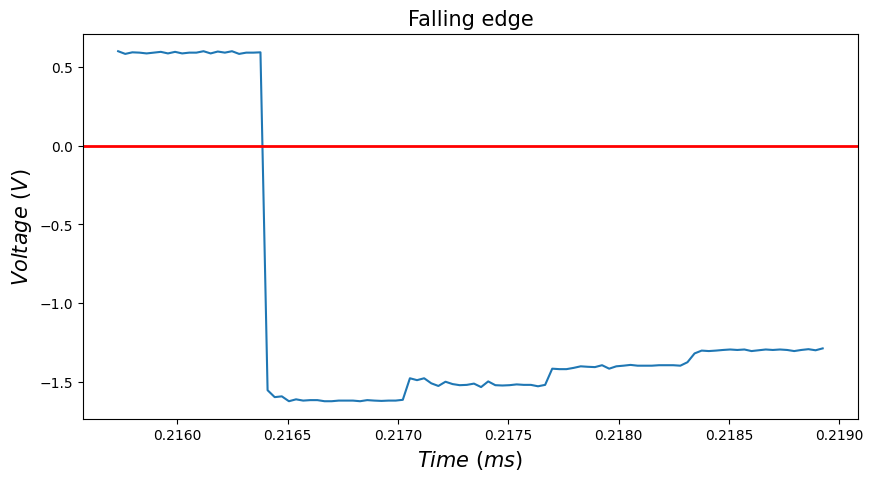

In [10]:
falling_edge_indx = short_93m_edges_indices['falling_edges'][0]
t_falling_seg, v_falling_seg = ut.win_generator(v_short_93m, t, falling_edge_indx, win_size, prior_samples)

plot_title = 'Falling edge'
ut.single_plot(t_falling_seg, v_falling_seg, plot_title)

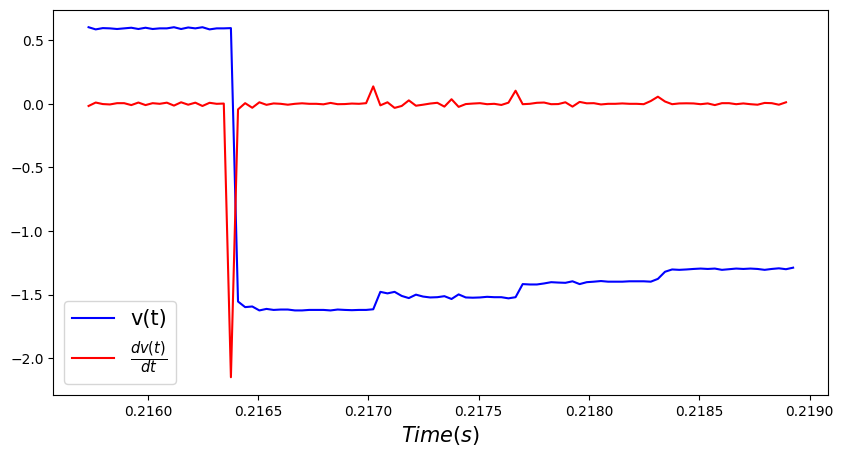

In [11]:
#let's plot
s_falling_derivative = ut.sig_derivative(v_falling_seg, t_falling_seg)

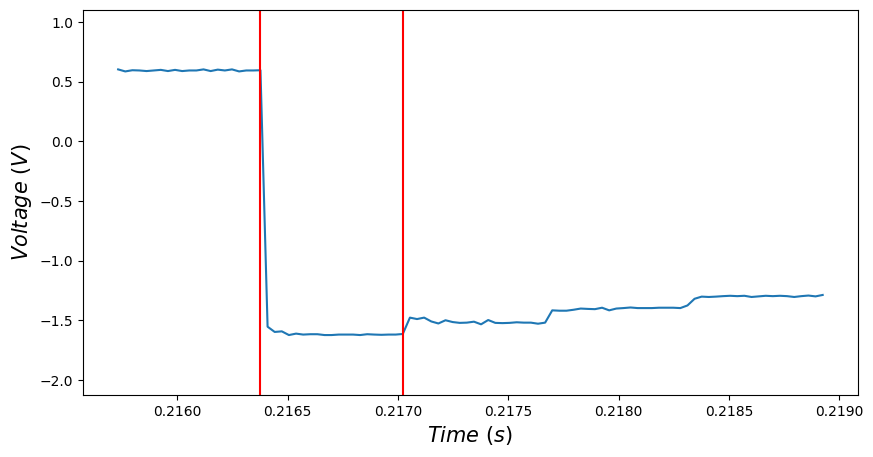

Timed delay is 0.0006452258129038824 ms


In [12]:
t_falling_delay = ut.time_delay(v_falling_seg, t_falling_seg, display=True)
print('Timed delay is {} ms'.format(t_falling_delay))

In [13]:
p_falling_fault = ut.fault_point(t_falling_delay, c, vf)

print('Distance to the fault is {} m'.format(p_falling_fault))

Distance to the fault is 94.7126970761609 m


In [14]:
#model performance
performance = ut.performance_metrics(93.26, p_falling_fault, metrics=['mse'])
print('Model performance metrics outcome for a single falling edge:', performance)

Model performance metrics outcome for a single falling edge: Metrics(mse=2.1103287950863927, rmse=1.452697076160888)


### Average time delay from the signal

In the following sections, we'll obtain time delay from all rising and falling edges and compute their average

In [15]:
#locate rising rising edges and a falling edges in the signal
short_93m_edges_indices = ut.edges_detection(v_short_93m, t, num_edges, win_size, prior_samples, overlap_threshold)

print(short_93m_edges_indices)

{'rising_edges': [8533, 4652, 765], 'falling_edges': [6707, 2823]}


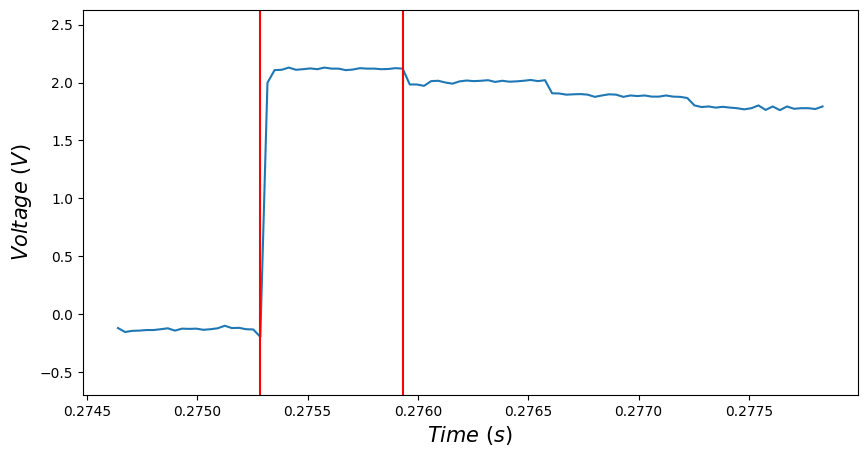

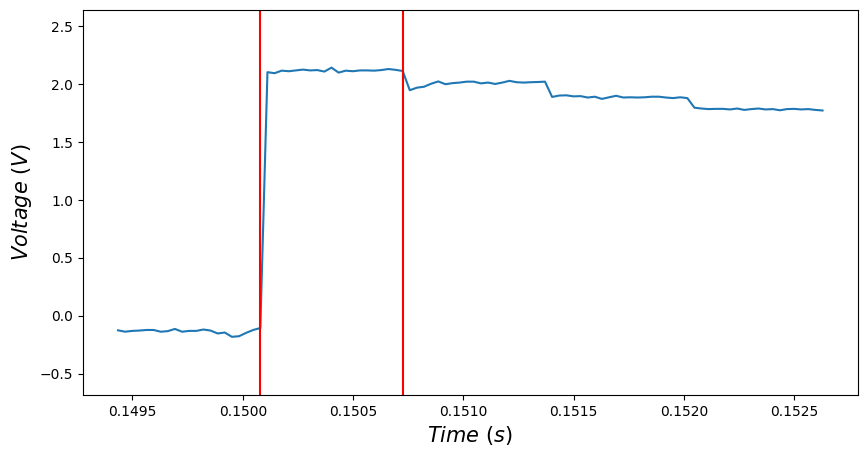

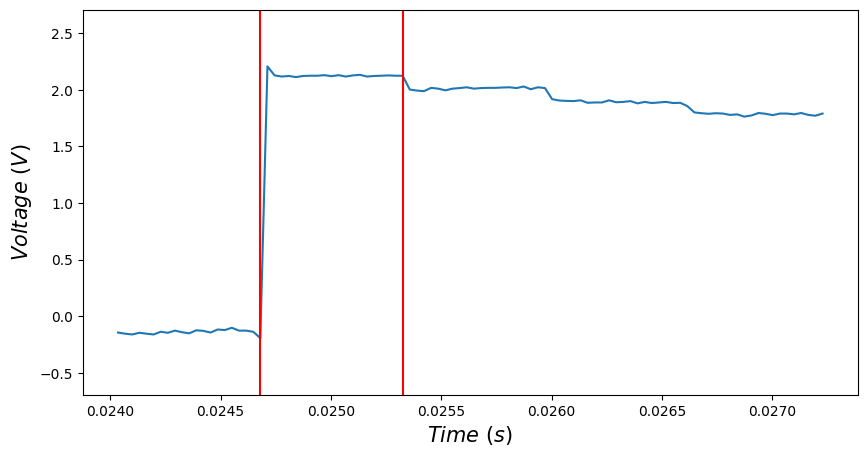

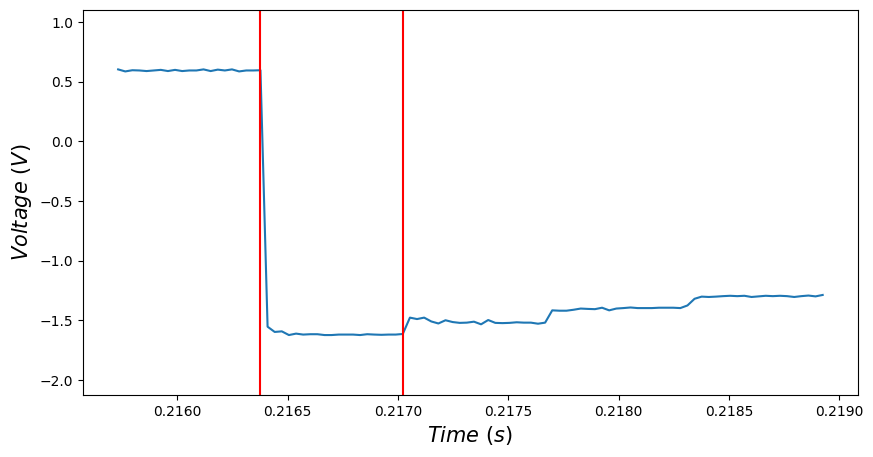

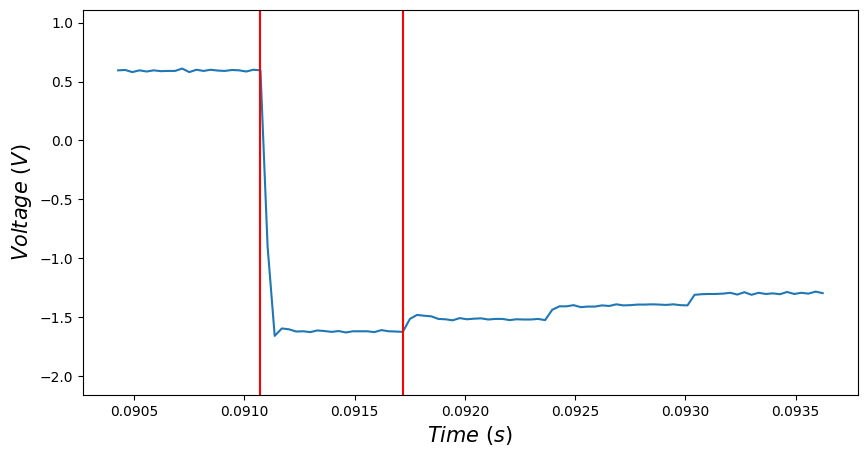

[0.00064523 0.00064523 0.00064523 0.00064523 0.00064523]
Average time delay is 0.0006452258129038713 ms


In [16]:
avg_t_short_93m_delay,  t_short_93m_delays = ut.avg_delay(short_93m_edges_indices, win_size, v_short_93m, t, prior_samples)

print(t_short_93m_delays)
print('Average time delay is {} ms'.format(avg_t_short_93m_delay))

In [17]:
#let's compute distance to the fault using the average time delay
p_short_fault = ut.fault_point(avg_t_short_93m_delay, c, vf)

print('Distance to the fault is {} m'.format(p_short_fault))

Distance to the fault is 94.71269707615927 m


In [18]:
#model performance
performance = ut.performance_metrics(93.26, p_short_fault, metrics=['mse'])
print('Model performance metrics outcome for the whole signal:', performance)

Model performance metrics outcome for the whole signal: Metrics(mse=2.110328795081686, rmse=1.452697076159268)


Let's load all files under open circuit, obtain time delay from each signal and compute the length of the cable

In [19]:
short_93m_circuit_files = {}
files = []
avg_time_delay_ms = []
distance_to_fault = []
e_values = []
paths = ut.file_paths(short_93m_files_dir) #generate paths to each file

for file_path in paths:
    v_short_93m = ut.file_loader(file_path) #load the file
    valid_file = ut.file_validity(v_short_93m, num_samples, threshold) #check if there was a bus conflict while saving the file
    
    if valid_file:
        short_93m_edges_indices = ut.edges_detection(v_short_93m, t, num_edges, win_size, prior_samples, overlap_threshold)
        avg_t_short_93m_delay,  t_short_93m_delays = ut.avg_delay(short_93m_edges_indices, win_size, v_short_93m, t, prior_samples, display=False)
        p_short_fault = ut.fault_point(avg_t_short_93m_delay, c, vf)
        
        files.append(file_path)
        avg_time_delay_ms.append(avg_t_short_93m_delay)
        distance_to_fault.append(p_short_fault)
        e_values.append(93.26)
        
short_93m_circuit_files = {'files': files,
                      'avg_time_delay_ms': avg_time_delay_ms,
                      'distance_to_fault': distance_to_fault}

df_short_93m = pd.DataFrame(short_93m_circuit_files)
        
df_short_93m

,files,avg_time_delay_ms,distance_to_fault
0,./data/short-circuit/93m/short-106-93-1.csv,0.000645,94.712697
1,./data/short-circuit/93m/short-106-93-10.csv,0.000645,94.712697
2,./data/short-circuit/93m/short-106-93-11.csv,0.000645,94.712697
3,./data/short-circuit/93m/short-106-93-12.csv,0.000645,94.712697
4,./data/short-circuit/93m/short-106-93-13.csv,0.000645,94.712697
5,./data/short-circuit/93m/short-106-93-14.csv,0.000645,94.712697
6,./data/short-circuit/93m/short-106-93-15.csv,0.000645,94.712697
7,./data/short-circuit/93m/short-106-93-16.csv,0.000645,94.712697
8,./data/short-circuit/93m/short-106-93-17.csv,0.000645,94.712697
9,./data/short-circuit/93m/short-106-93-18.csv,0.000645,94.712697


In [20]:
#model performance
performance = ut.performance_metrics(e_values, distance_to_fault)
print('Model performance metrics outcome for all data:', performance)

Model performance metrics outcome for all data: Metrics(mse=2.1103287950823146, rmse=1.4526970761594844, mae=1.4526970761594844, irm=1.0)


### 98.56 m
Short circuit at 98.56 m from the input port

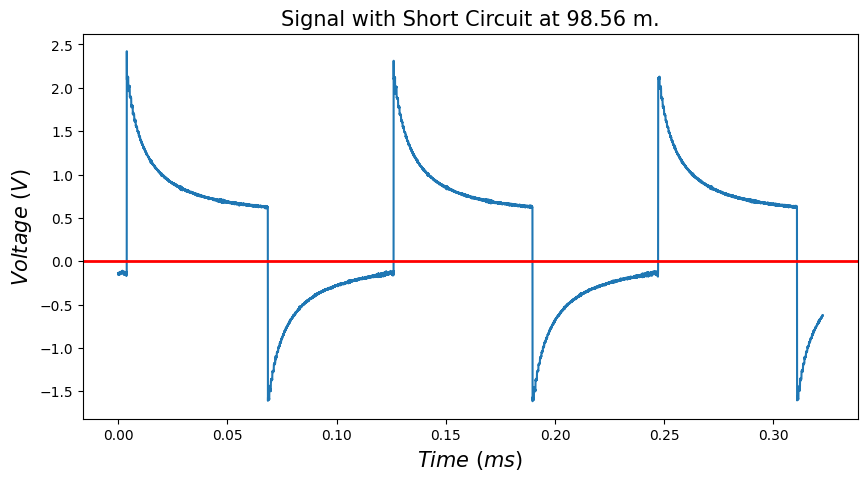

In [21]:
short_99m_files_dir = './data/short-circuit/99m'

#load a random file
v_short_99m = ut.random_file_load(short_99m_files_dir, num_samples, threshold)

#plot the loaded signal
ut.single_plot(t, v_short_99m, 'Signal with Short Circuit at 98.56 m.')

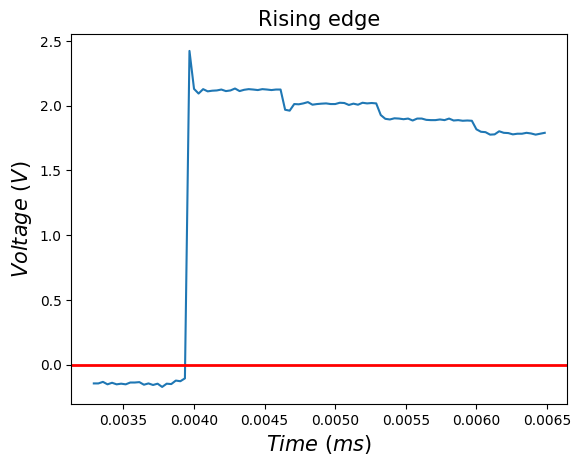

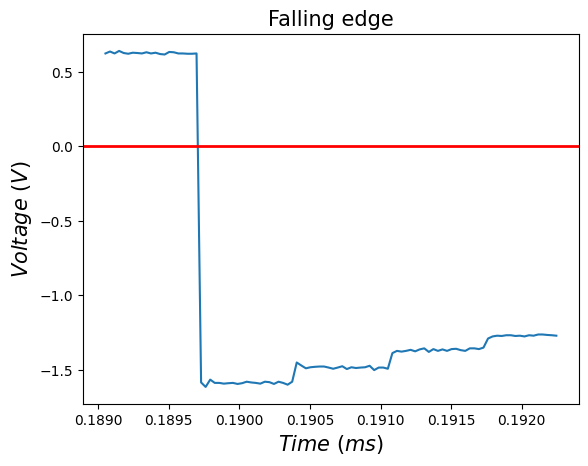

In [22]:
#locate rising a rising edge and a falling edge in the signal
short_99m_edges_indices = ut.edges_detection(v_short_99m, t, _num_edges, win_size, prior_samples, overlap_threshold)

#plot rising and falling edges
ut.edges_plots(v_short_99m, t, short_99m_edges_indices, win_size, prior_samples)

#### 1. Rising edge

Change point detection on a rising edge

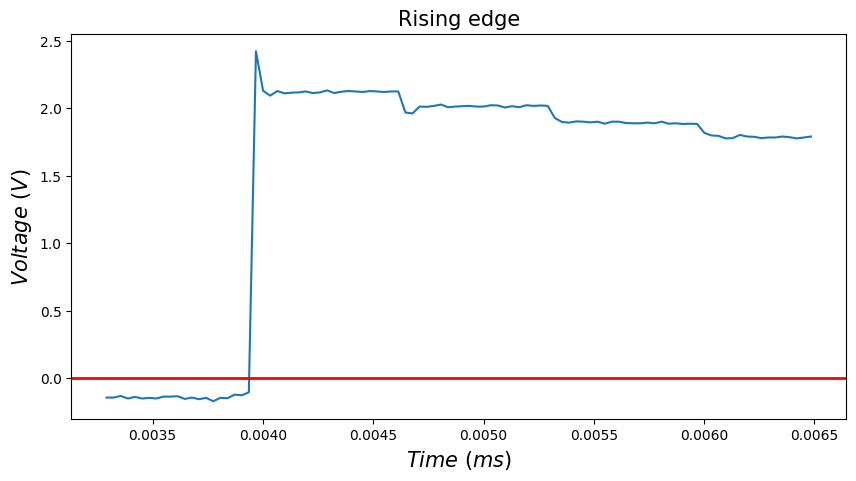

In [23]:
rising_edge_indx = short_99m_edges_indices['rising_edges'][0]
t_rising_seg, v_rising_seg = ut.win_generator(v_short_99m, t, rising_edge_indx, win_size, prior_samples)

plot_title = 'Rising edge'
ut.single_plot(t_rising_seg, v_rising_seg, plot_title)

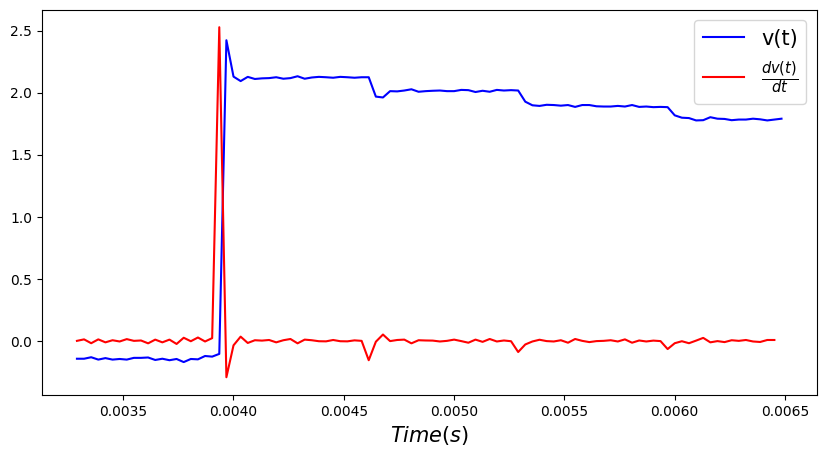

In [24]:
#let's plot the derivative of the signal and the signal
s_rising_derivative = ut.sig_derivative(v_rising_seg, t_rising_seg)

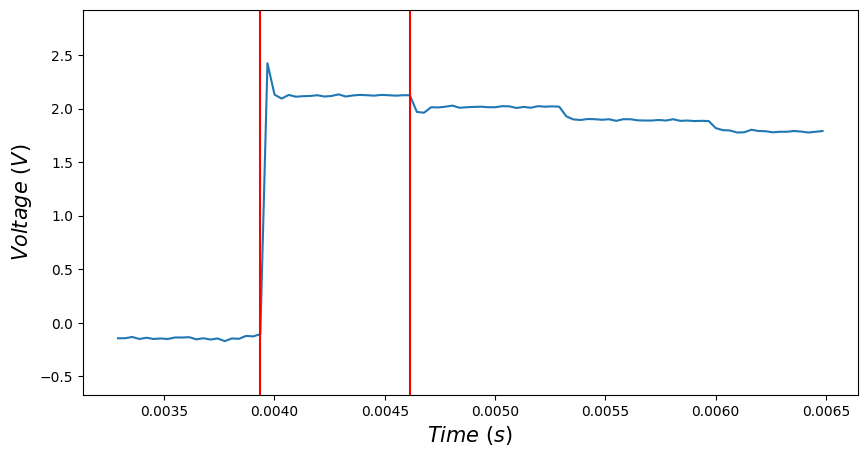

Timed delay is 0.0006774871035490652 ms


In [25]:
t_rising_delay = ut.time_delay(v_rising_seg, t_rising_seg, display=True)
print('Timed delay is {} ms'.format(t_rising_delay))

In [26]:
p_rising_fault = ut.fault_point(t_rising_delay, c, vf)

print('Distance to the fault is {} m'.format(p_rising_fault))

Distance to the fault is 99.4483319299673 m


In [27]:
#model performance
performance = ut.performance_metrics(98.56, p_rising_fault, metrics=['mse'])
print('Model performance metrics outcome for a single rising edge:', performance)

Model performance metrics outcome for a single rising edge: Metrics(mse=0.7891336177994163, rmse=0.8883319299672934)


#### 2. Falling edge

Change point detection on a falling edge

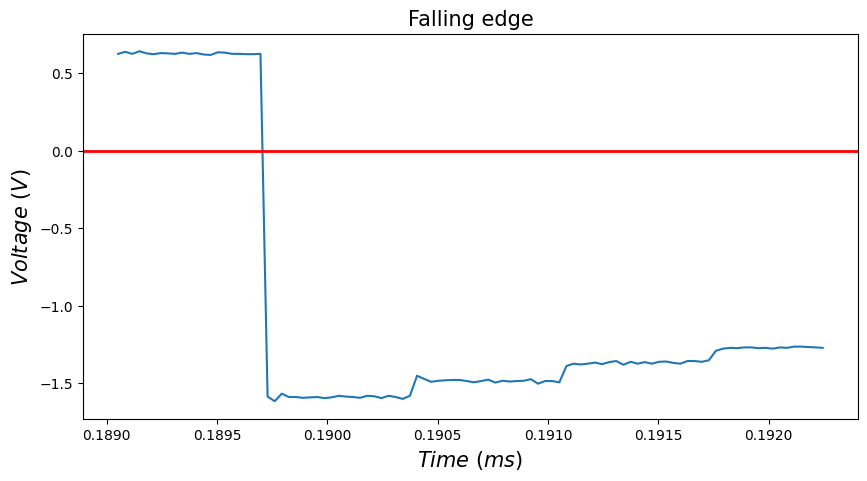

In [28]:
falling_edge_indx = short_99m_edges_indices['falling_edges'][0]
t_falling_seg, v_falling_seg = ut.win_generator(v_short_99m, t, falling_edge_indx, win_size, prior_samples)

plot_title = 'Falling edge'
ut.single_plot(t_falling_seg, v_falling_seg, plot_title)

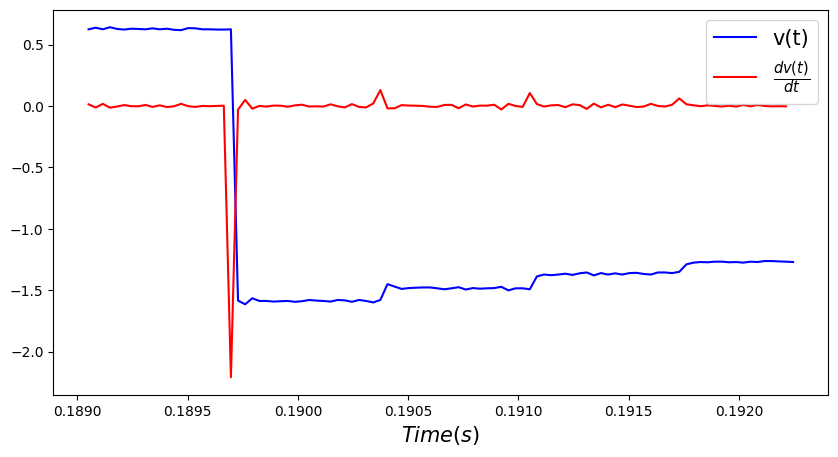

In [29]:
#let's plot
s_falling_derivative = ut.sig_derivative(v_falling_seg, t_falling_seg)

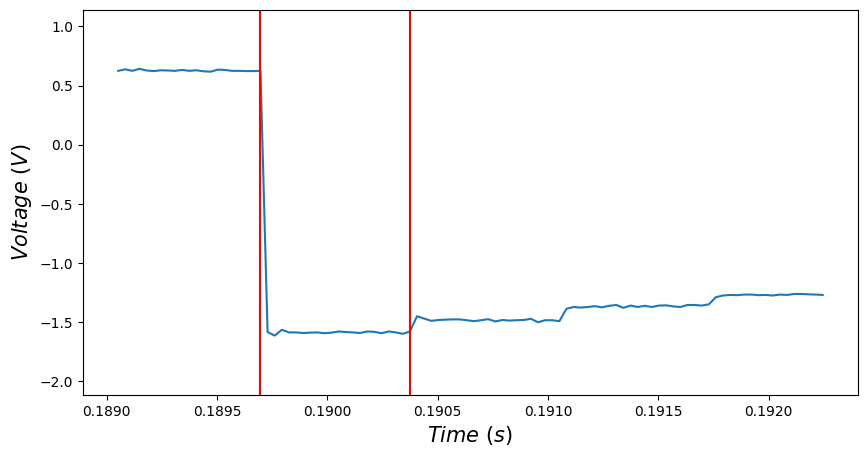

Timed delay is 0.0006774871035490626 ms


In [30]:
t_falling_delay = ut.time_delay(v_falling_seg, t_falling_seg, display=True)
print('Timed delay is {} ms'.format(t_falling_delay))

In [31]:
p_falling_fault = ut.fault_point(t_falling_delay, c, vf)

print('Distance to the fault is {} m'.format(p_falling_fault))

Distance to the fault is 99.4483319299669 m


In [32]:
#model performance
performance = ut.performance_metrics(98.56, p_falling_fault, metrics=['mse'])
print('Model performance metrics outcome for a single falling edge:', performance)

Model performance metrics outcome for a single falling edge: Metrics(mse=0.7891336177987093, rmse=0.8883319299668955)


### Average time delay from the signal

In the following sections, we'll obtain time delay from all rising and falling edges and compute their average

In [33]:
#locate rising rising edges and a falling edges in the signal
short_99m_edges_indices = ut.edges_detection(v_short_99m, t, num_edges, win_size, prior_samples, overlap_threshold)

print(short_99m_edges_indices)

{'rising_edges': [7663, 3909, 122], 'falling_edges': [5880, 9634, 2124]}


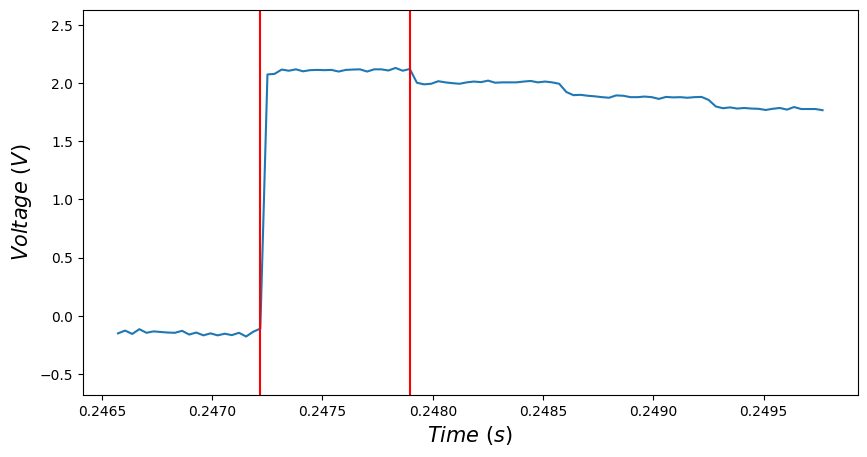

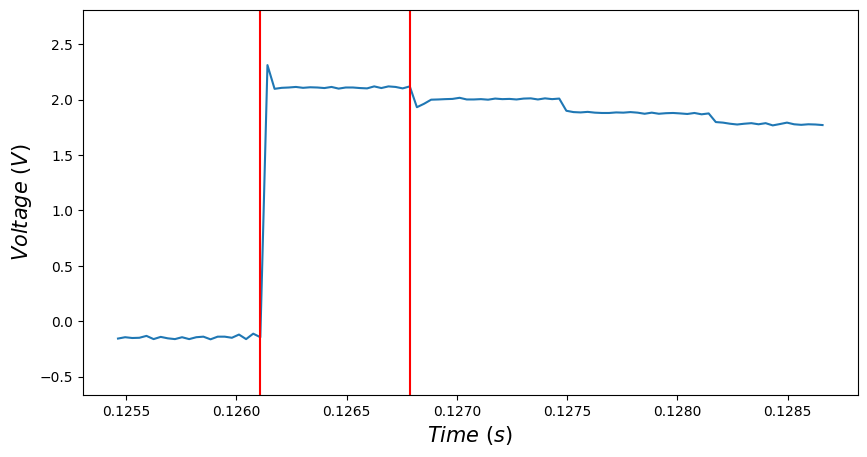

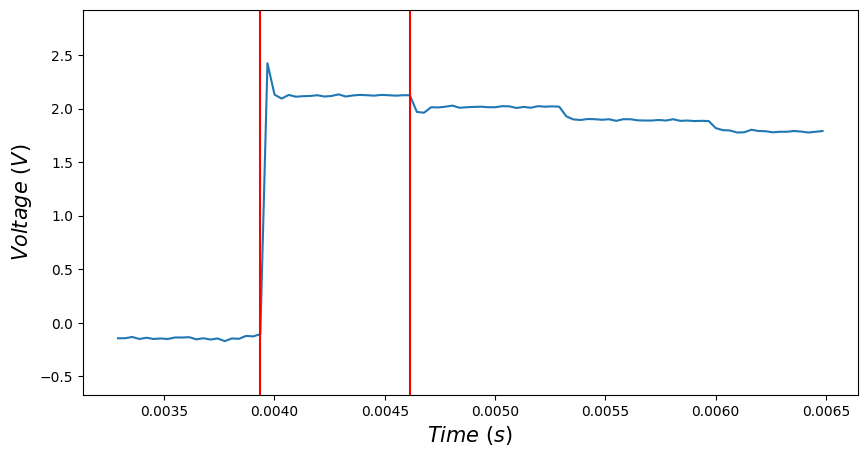

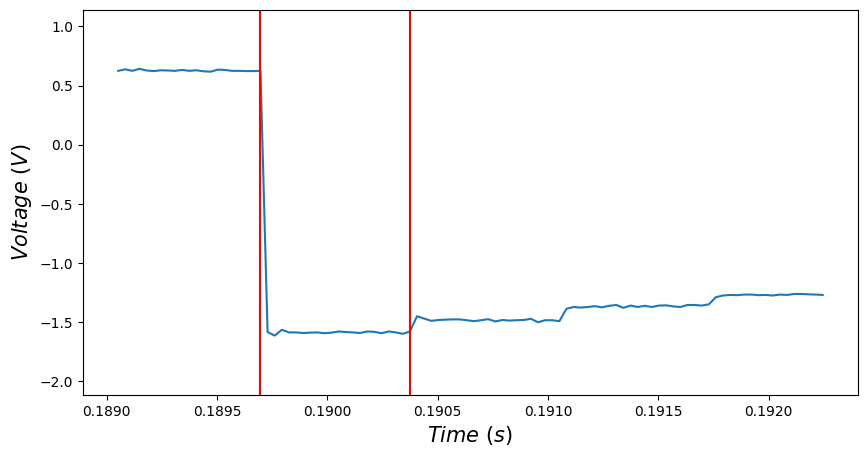

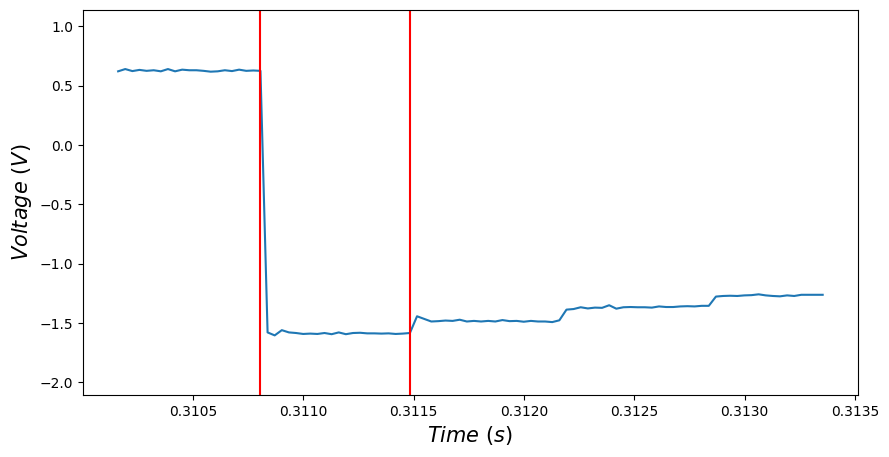

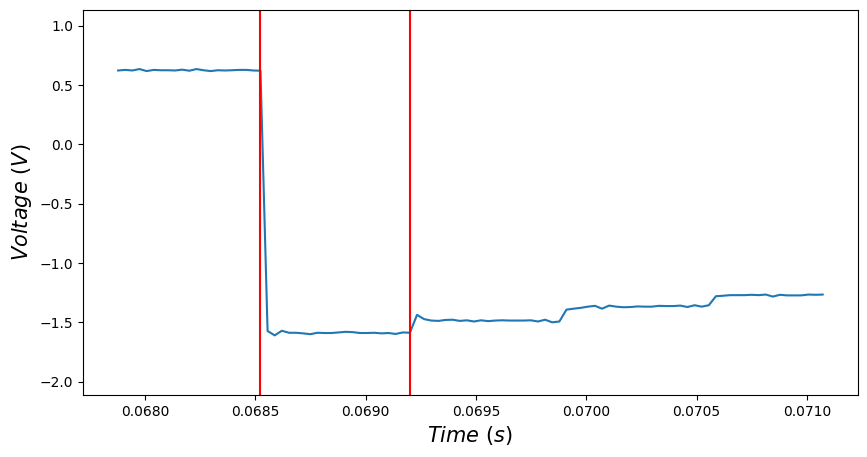

[0.00067749 0.00067749 0.00067749 0.00067749 0.00067749 0.00067749]
Average time delay is 0.0006774871035490792 ms


In [34]:
avg_t_short_99m_delay,  t_short_99m_delays = ut.avg_delay(short_99m_edges_indices, win_size, v_short_99m, t, prior_samples)

print(t_short_99m_delays)
print('Average time delay is {} ms'.format(avg_t_short_99m_delay))

In [35]:
#let's compute distance to the fault using the average time delay
p_short_fault = ut.fault_point(avg_t_short_99m_delay, c, vf)

print('Distance to the fault is {} m'.format(p_short_fault))

Distance to the fault is 99.44833192996934 m


In [36]:
#model performance
performance = ut.performance_metrics(98.56, p_short_fault, metrics=['mse'])
print('Model performance metrics outcome for the whole signal:', performance)

Model performance metrics outcome for the whole signal: Metrics(mse=0.7891336178030519, rmse=0.8883319299693397)


Let's load all files under open circuit, obtain time delay from each signal and compute the length of the cable

In [37]:
short_99m_circuit_files = {}
files = []
avg_time_delay_ms = []
distance_to_fault = []
e_values = []
paths = ut.file_paths(short_99m_files_dir) #generate paths to each file

for file_path in paths:
    v_short_99m = ut.file_loader(file_path) #load the file
    valid_file = ut.file_validity(v_short_99m, num_samples, threshold) #check if there was a bus conflict while saving the file
    
    if valid_file:
        short_99m_edges_indices = ut.edges_detection(v_short_99m, t, num_edges, win_size, prior_samples, overlap_threshold)
        avg_t_short_99m_delay,  t_short_99m_delays = ut.avg_delay(short_99m_edges_indices, win_size, v_short_99m, t, prior_samples, display=False)
        p_short_fault = ut.fault_point(avg_t_short_99m_delay, c, vf)
        
        files.append(file_path)
        avg_time_delay_ms.append(avg_t_short_99m_delay)
        distance_to_fault.append(p_short_fault)
        e_values.append(98.56)
        
short_99m_circuit_files = {'files': files,
                      'avg_time_delay_ms': avg_time_delay_ms,
                      'distance_to_fault': distance_to_fault}

df_short_99m = pd.DataFrame(short_99m_circuit_files)
        
df_short_99m

,files,avg_time_delay_ms,distance_to_fault
0,./data/short-circuit/99m/short-106-99-1.csv,0.000677,99.448332
1,./data/short-circuit/99m/short-106-99-10.csv,0.000677,99.448332
2,./data/short-circuit/99m/short-106-99-11.csv,0.000677,99.448332
3,./data/short-circuit/99m/short-106-99-13.csv,0.000677,99.448332
4,./data/short-circuit/99m/short-106-99-14.csv,0.000677,99.448332
5,./data/short-circuit/99m/short-106-99-15.csv,0.000677,99.448332
6,./data/short-circuit/99m/short-106-99-16.csv,0.000677,99.448332
7,./data/short-circuit/99m/short-106-99-17.csv,0.000677,99.448332
8,./data/short-circuit/99m/short-106-99-18.csv,0.000677,99.448332
9,./data/short-circuit/99m/short-106-99-19.csv,0.000677,99.448332


In [38]:
#model performance
performance = ut.performance_metrics(e_values, distance_to_fault)
print('Model performance metrics outcome for all data:', performance)

Model performance metrics outcome for all data: Metrics(mse=0.7891336177991891, rmse=0.8883319299671656, mae=0.8883319299671655, irm=1.0)
